# Martta tekrar

In [1]:
!pip install statsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 3.9 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 6.6 MB/s eta 0:00:00
  Created wheel for fugue-sql-antlr: filename=fugue_sql_antlr-0.2.0-py3-none-any.whl size=158196 sha256=ba10c637003c6c32275a2668d19910b2a1f6c9c6100e196b4e1677150845cd58
  Stored in directory: /home/jovyan/.cache/pip/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from   scipy import stats

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

/opt/conda/lib/python3.11/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/opt/conda/lib/python3.11/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
plt.rcParams["figure.figsize"] = 12,6

## Read Data

In [4]:
path        = "satis.xlsx"
df          = pd.read_excel(path, index_col="DateId", parse_dates=True)
df.head()

,DistributorId,CustomerId,Channel-Id,ProductId,ProductBasePrice,DiscountRate,Amount,Total,NetTotal,InvoiceTip
DateId,,,,,,,,,,
2020-04-09,10,36485,274,12555,9.52,0,960,9139.20,10784.26,SELLING
2020-04-09,10,36485,274,12556,12.68,0,1200,15216.00,17954.88,SELLING
2020-04-09,10,36485,274,12557,13.62,0,1392,18959.04,22371.67,SELLING
2020-04-09,10,36485,274,12558,10.22,0,816,8339.52,9840.63,SELLING
2020-04-09,10,36485,274,12563,23.92,0,816,19518.72,23032.09,SELLING


## Investigate Data

In [5]:
# Check nullity
df.isna().sum()

DistributorId       0
CustomerId          0
Channel-Id          0
ProductId           0
ProductBasePrice    0
DiscountRate        0
Amount              0
Total               0
NetTotal            0
InvoiceTip          0
dtype: int64

In [6]:
# Check duplicates
duplicate_check_df         = df.copy()
duplicate_check_df["Date"] = duplicate_check_df.index
print(duplicate_check_df.duplicated().sum(), "duplicates")

del duplicate_check_df

0 duplicates


In [7]:
df["InvoiceTip"].value_counts(normalize=True)

InvoiceTip
SELLING                   0.824781
DAMAGED_SELLING_RETURN    0.154770
SELLING_RETURN            0.020449
Name: proportion, dtype: float64

In [8]:
def plot_amount_with_selling_type(df, lower_limit=None, upper_limit=None, plot_lim=None, title="Untitled"):
    size = 10
    
    selling_data = df.query("InvoiceTip == 'SELLING'")

    if lower_limit:
        plt.axhline(lower_limit, color="black")

    if upper_limit:
        plt.axhline(upper_limit, color="black")
    
    plt.scatter(x=selling_data.index, 
                y=selling_data["Amount"].values,
                s=size, 
                label="Selling")
    
    selling_data = df.query("InvoiceTip == 'SELLING_RETURN'")
    plt.scatter(x=selling_data.index, 
                y=selling_data["Amount"].values,
                s=size, 
                label="Return")
    
    selling_data = df.query("InvoiceTip == 'DAMAGED_SELLING_RETURN'")
    plt.scatter(x=selling_data.index, 
                y=selling_data["Amount"].values,
                s=size, 
                label="Damaged Return")
    
    plt.xlabel("Date")
    plt.ylabel("Amount")
    
    if plot_lim:
        plt.ylim(-plot_lim, plot_lim)
        
    plt.title(title)
    plt.legend()
    plt.show()

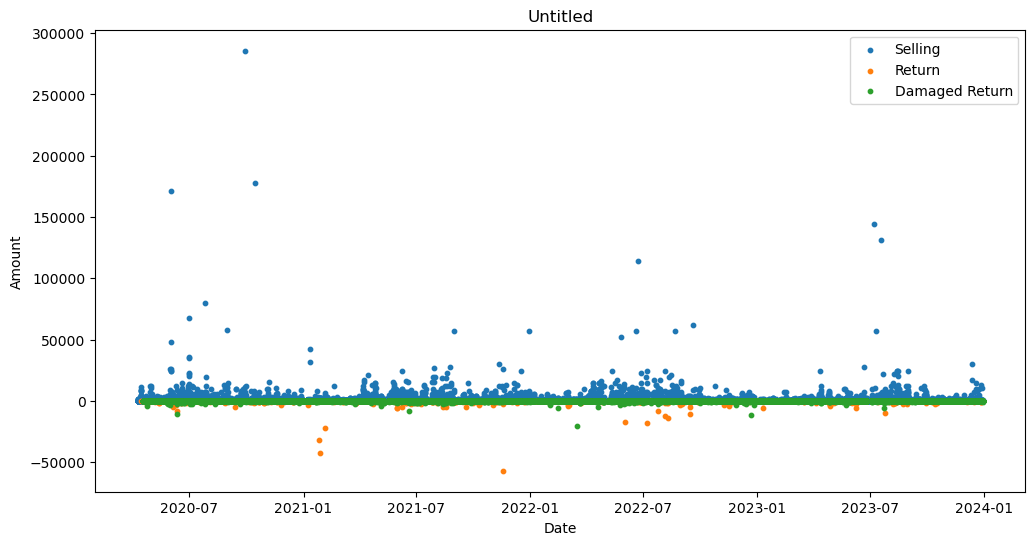

In [9]:
plot_amount_with_selling_type(df)

## Outlier Detection

In [10]:
mean        = df["Amount"].mean()
std         = df["Amount"].std()

z_limit     = 10
z_threshold = mean + z_limit * std
print(z_threshold)

8573.62560664513


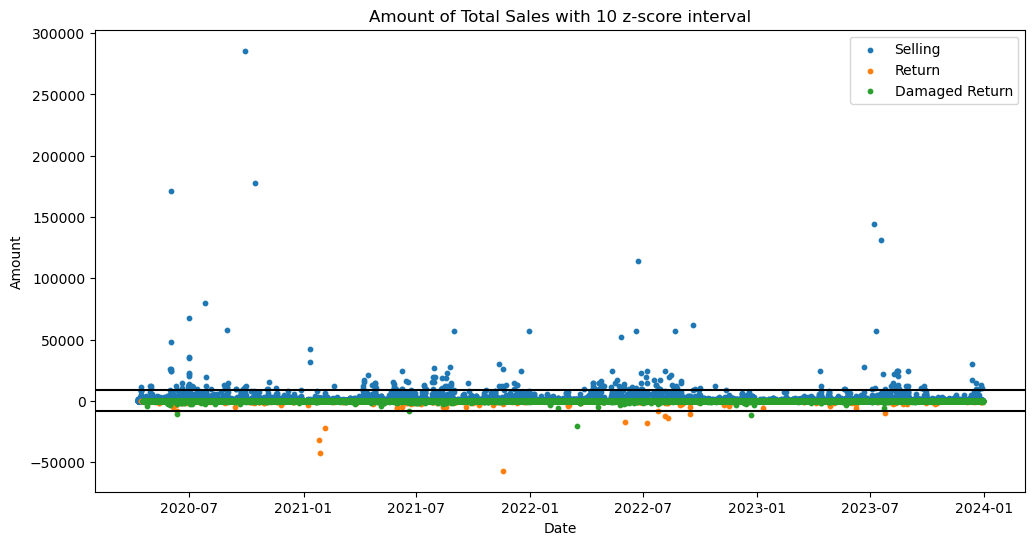

In [11]:
plot_amount_with_selling_type(df, lower_limit=-z_threshold, upper_limit=z_threshold, 
                              title=f"Amount of Total Sales with {z_limit} z-score interval")

In [12]:
# Check outliers

outlier_data = df.query("Amount > @z_threshold or Amount < -@z_threshold").copy()
inlier_data  = df.drop(outlier_data.index)
print(f"{round(len(outlier_data) / len(df), 4)} of data is considered as outlier at {z_limit} * std level.")
print(
f"""
Mean before filtering = {df["Amount"].mean()}
Mean after filtering  = {inlier_data["Amount"].mean()}
""")

0.0006 of data is considered as outlier at 10 * std level.

Mean before filtering = 57.85698443116488
Mean after filtering  = 43.71386413423376



Frequenct of products in outlier data

In [13]:
outlier_data["ProductId"].value_counts().head()

ProductId
12555    126
12569     37
12556     24
12659     10
12557      8
Name: count, dtype: int64

### Endogenous Outlier Detection 

In [14]:
# Z Score of Amount by ProductId
df['AmountZScore'] = df.groupby('ProductId')['Amount'].transform(stats.zscore)

There are several null z-scores due to low amount. It would be best to drop these.

In [15]:
df["AmountZScore"].isna().sum()

18

In [16]:
df = df.dropna()

In [17]:
# Endogenous Outlier Detection
outlier_ratio_per_product = (
    df[df["AmountZScore"] > z_limit].groupby("ProductId")["AmountZScore"].count().sort_values(ascending=False) / 
    df["ProductId"].value_counts()).rename("ratio").fillna(0)
outlier_info_df = pd.merge(left=outlier_ratio_per_product, 
                           right=df["ProductId"].value_counts(), 
                           right_index=True,
                           left_index= True,
                           how="outer")
outlier_info_df.sort_values(by="count", ascending=False).head()

,ratio,count
ProductId,,
12555,0.000767,20855
12556,0.001514,13873
12557,0.002066,13066
12569,0.001506,11954
12563,0.000938,10660


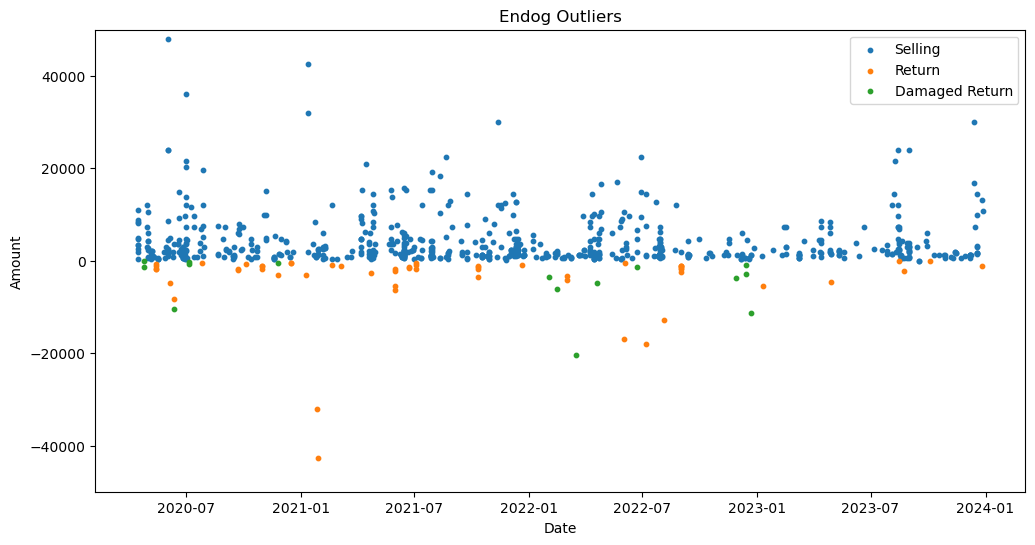

In [18]:
plot_amount_with_selling_type(
    df[(df["AmountZScore"].abs() > z_limit)], 
    plot_lim=50_000,
    title="Endog Outliers"
)

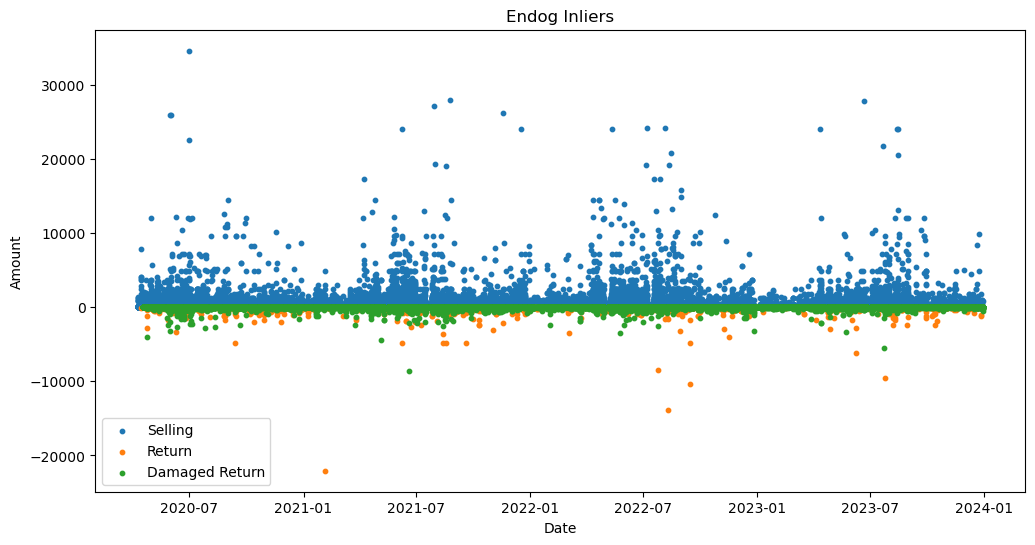

In [19]:
endog_inliers = df[df["AmountZScore"].abs() < z_limit].copy()
plot_amount_with_selling_type(
    endog_inliers,
    title="Endog Inliers")

### Get filtered df

In [20]:
filtered_df = endog_inliers[endog_inliers["InvoiceTip"].isin(["SELLING", "SELLING_RETURN"])].copy()
filtered_df.head()

,DistributorId,CustomerId,Channel-Id,ProductId,ProductBasePrice,DiscountRate,Amount,Total,NetTotal,InvoiceTip,AmountZScore
DateId,,,,,,,,,,,
2020-04-09,10,36485,274,12555,9.52,0,960,9139.20,10784.26,SELLING,0.188442
2020-04-09,10,36485,274,12556,12.68,0,1200,15216.00,17954.88,SELLING,1.399510
2020-04-09,10,36485,274,12557,13.62,0,1392,18959.04,22371.67,SELLING,2.848003
2020-04-09,10,36485,274,12558,10.22,0,816,8339.52,9840.63,SELLING,3.419612
2020-04-09,10,36485,274,12563,23.92,0,816,19518.72,23032.09,SELLING,2.257410


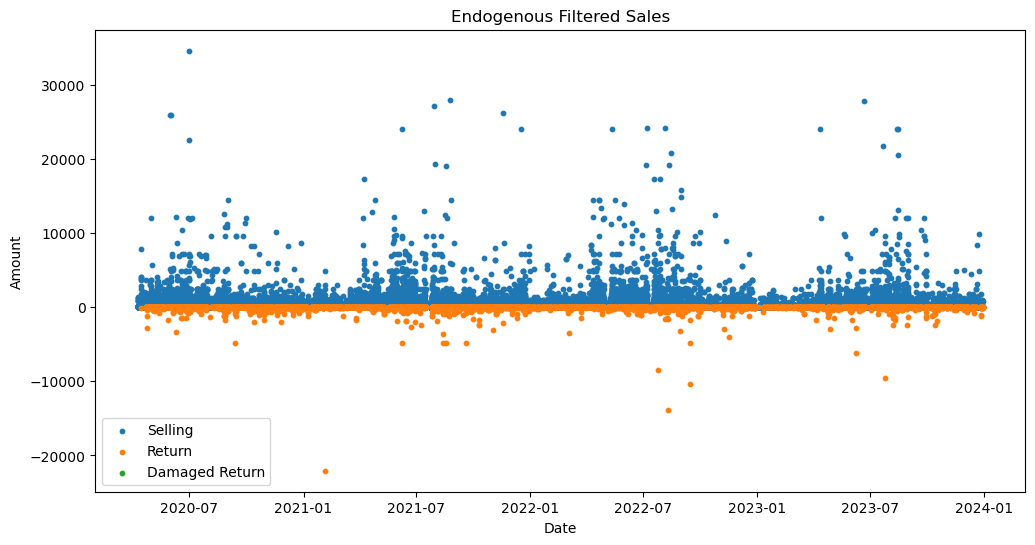

In [21]:
plot_amount_with_selling_type(filtered_df,
                              title="Endogenous Filtered Sales")

## Feature Engineering and Product Filtering

In [22]:
first_date_in_df, last_date_in_df = filtered_df.index.min(), filtered_df.index.max()
filtered_df["DaystoLastDateInDf"]  = (last_date_in_df - filtered_df.index).days 

In [23]:
print(f"First sale on {first_date_in_df.date()} \nLast sale on  {last_date_in_df.date()}")
print(f"Windows is {round((last_date_in_df - first_date_in_df).days / 364, 2)} years")

First sale on 2020-04-09 
Last sale on  2023-12-30
Windows is 3.74 years


### Product Details and Eligible Products

In [24]:
outlier_info_df.columns = ["Outlier Ratio", "Outlier Count"]
outlier_info_df.head()

,Outlier Ratio,Outlier Count
ProductId,,
12555,0.000767,20855
12556,0.001514,13873
12557,0.002066,13066
12558,0.001400,2143
12559,0.001361,1469


In [25]:
inactive_threshold = 364
long_enough        = 364
min_sales          = 100
date_quantile      = .95

filtered_df["Date"] = pd.to_datetime(filtered_df.index)

product_details                                 = filtered_df.groupby("ProductId")["Date"].agg(["min", "max"])
product_details.columns                         = ["FirstSaleDate", "LastSaleDate"]

# Date Related
product_details["DaysSoldFor"]                  = (product_details["LastSaleDate"] - product_details["FirstSaleDate"]).dt.days
product_details["DaysSinceLastSaleDate"]        = (last_date_in_df - product_details["LastSaleDate"]).dt.days

# Validity of the product
product_details["IsActive"]                     = product_details["DaysSinceLastSaleDate"].apply(lambda day: day < inactive_threshold)
product_details["IsSoldEnough"]                 = product_details["DaysSoldFor"].apply(lambda days: days > long_enough)

# Sales volume
product_details["TotalSaleAmount"]              = filtered_df.groupby("ProductId")["Amount"].sum()
product_details["MeanSaleAmountPerMonth"]       = product_details["TotalSaleAmount"] / (product_details["DaysSoldFor"] / 30)

# Maybe we can add quantile test?

query_              = """IsActive               == True and \
                         IsSoldEnough           == True and \
                         MeanSaleAmountPerMonth >= @min_sales
                      """
eligible_products                               = product_details.query(query_).copy()

print(f"{eligible_products.count().min()} of {len(df.ProductId.unique())} products are eligible for forecasting.")

del filtered_df["Date"]

180 of 282 products are eligible for forecasting.


In [26]:
filtered_df.columns

Index(['DistributorId', 'CustomerId', 'Channel-Id', 'ProductId',
       'ProductBasePrice', 'DiscountRate', 'Amount', 'Total', 'NetTotal',
       'InvoiceTip', 'AmountZScore', 'DaystoLastDateInDf'],
      dtype='object')

In [27]:
numerical_df = filtered_df[['ProductId', 'DiscountRate', 'Amount']].copy()
numerical_df

,ProductId,DiscountRate,Amount
DateId,,,
2020-04-09,12555,0,960
2020-04-09,12556,0,1200
2020-04-09,12557,0,1392
2020-04-09,12558,0,816
2020-04-09,12563,0,816
...,...,...,...
2023-04-13,81412,0,5
2023-04-13,81470,0,276
2023-04-13,81619,0,6


## Forecasting